# bbSelect similarity
Author: Francesco Rianjongdee\
This notebook explains how bbSelect fingerprints can be used to find similar R-groups.\
This offers an alternative to using ECFP fingerprints, which are primarily sub-structure based\
bbSelect fingerprints offer a similarity based on placement of pharmacophores, which can be beneficial in some situations.\
There is a high sparsity in bbSelect fingerprints, and so some modifications are required to give reasonable results.\
This has not been fully tested or evaluated!

In [1]:
import os
import sys
sys.path.append('../')
from bbSelectPartitioning import selection_maps, get_fp_from_memory_mapped_db 
from bbSelect import process_db, Timer, get_bbgap_configuration, SelectCompounds
from rdkit import Chem # Import RDkit for visualisation
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw, PandasTools
from rdkit import DataStructs
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import chain
import copy as cp
plt.rcParams['figure.figsize'] = [15,10]# Set visualisation parameters
np.set_printoptions(threshold=np.inf)
np.set_printoptions(linewidth=200)

#### For this notebook, the set of commercially available Enamine carboxylic acids will be used to illustrate

In [2]:
### Load in the reference set of acids

input_ref = '../data/enamine_acids/enamine_acids_filtered_omega.ref'
input_bin = '../data/enamine_acids/enamine_acids_filtered_omega.bin'
inref = open(input_ref, 'r')
DBconfiguration = get_bbgap_configuration(inref)
inref.close()
## Initiate mGAP object
mGAPclustering = selection_maps(fp = DBconfiguration['density_fp'],numX = DBconfiguration['numX'],numY = DBconfiguration['numY'],pharmacophore_dict = DBconfiguration['pharmacophores'],excess_bits = DBconfiguration['excess_bits'])
mGAPclustering.Coverage(bin_loc = input_bin, ref_loc = input_ref) ## Enumerate coverage

In [3]:
def bleed_array(array):
    """
    Transforms an array by making each of the adjacent 8 cells to each filled cell is also filled.
    This is used to add "fuzzyness" to the similarity
    :param array: np.array containing 1s and 0s
    """
    bleed_array = np.zeros((array.shape))
    for y in range(array.shape[0]):
        for x in range(array.shape[1]):
            if array[y,x] == 1:
                
                ## Check if you're at the edge of the array
                if y == array.shape[0]-1:
                    y_plus_1 = y
                else:
                    y_plus_1 = y+1
                if y == 0:
                    y_minus_1 = y
                else:
                    y_minus_1 = y-1
                if x == array.shape[1]-1:
                    x_plus_1 = x
                else:
                    x_plus_1 = x+1
                if x == 0:
                    x_minus_1 = x
                else:
                    x_minus_1 = x-1
                
                ## Update the array accordingly
                bleed_array[y,x] = 1             
                
                bleed_array[y_plus_1,x_plus_1] = 1
                bleed_array[y_minus_1,x_minus_1] = 1
                
                bleed_array[y_plus_1,x_minus_1] = 1
                bleed_array[y_minus_1,x_plus_1] = 1
                
                bleed_array[y,x_plus_1] = 1
                bleed_array[y,x_minus_1] = 1
                bleed_array[y_minus_1,x] = 1                
                bleed_array[y_plus_1,x] = 1
    return bleed_array

In [4]:
## Get the FP for compound
def GetFPsForMol(molname, mGAPclustering, DBconfiguration):
    
    mgap_bin_fp = mGAPclustering.GetCompoundFullFP(molname)
    mgap_str_fp = mgap_bin_fp.to01()
    mgap_pharmacophore_fp = {}
    for pharmacophore in DBconfiguration['pharmacophores'].keys():
        mgap_pharmacophore_fp[pharmacophore] = {}
        start_number = DBconfiguration['pmap_area'] * DBconfiguration['pharmacophores'][pharmacophore]
        end_number = start_number + DBconfiguration['pmap_area']

        mgap_pharmacophore_fp[pharmacophore]['fp'] = mgap_str_fp[start_number:end_number]

        mgap_pharmacophore_fp[pharmacophore]['fp_array'] = np.zeros((DBconfiguration['numY'], DBconfiguration['numX']))

        bit_position = 0
        for y in range(DBconfiguration['numY']):
            for x in range(DBconfiguration['numX']):
                bit = mgap_pharmacophore_fp[pharmacophore]['fp'][bit_position]
                mgap_pharmacophore_fp[pharmacophore]['fp_array'][y,x] = bit
                bit_position +=1

        mgap_pharmacophore_fp[pharmacophore]['fp_bleed_array'] = bleed_array(mgap_pharmacophore_fp[pharmacophore]['fp_array'])
    full_bleed_array = []
    for pharmacophore in mgap_pharmacophore_fp.keys():
        for row in mgap_pharmacophore_fp[pharmacophore]['fp_bleed_array']:
            full_bleed_array.extend(list(row))
    full_bleed_list = [str(int(i)) for i in full_bleed_array]
    full_bleed_fp = "".join(full_bleed_list)+'0'*DBconfiguration['excess_bits']
    
    return (mgap_pharmacophore_fp, full_bleed_fp)

## What does the bbSelect fingerprint of a molecule look like?
The bbSelect fingerprint records all the likely vectors of pharmacophores feature placements from an attachment point.\
The fingerprints can be visualised as a 2D grid for each pharmacophore, where the cells containing an instance of the pharmacophore are captured.\
Consider the molecule below, which contains a hydrogen bond acceptr ether oxygen

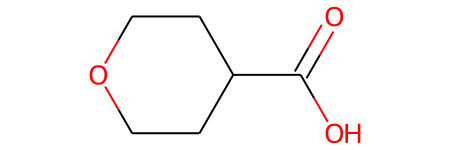

In [5]:
molname = 'EN300-12661'
## Get structure for compound
Chem.MolFromSmiles(mGAPclustering._ref_table.loc[molname]['smiles'])

#### In 1D, the fingerprint is stored as shown below
Each position of the fingerprint relates to a true region of 3D space where a pharmacophore may exist.

In [6]:
mGAPclustering.GetCompoundFullFP(molname)

bitarray('000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001010000000000000000000000000000000000000011000000000000000000000000000000000000001000000000000000000000000000000000000010000000

#### The fingerprint contains information for all the six pharmacophores.
The regions for each pharmacophore can be extracted from the fingerprint.\
For example, the region of the fingerprint containing information for the pharmacophore 01_A is shown below

In [7]:
mol_fps, mol_fuzzy_fp = GetFPsForMol(molname, mGAPclustering, DBconfiguration)

In [8]:
mol_fps['Acceptor']['fp']

'00000000000000000000000000000000000000000000000000000000000000010100000000000000000000000000000000000000110000000000000000000000000000000000000010000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000'

#### This fingerprint corresponds to a 30 x 15 grid, where each cell corresponds to a 0.65 Å<sup>3</sup> region of space.
The translation of this to an array is shown below\
This can be visualised as a heatmap, where each of the cells corresponds to a cell on the grid

In [9]:
mol_fps['Acceptor']['fp_array']

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

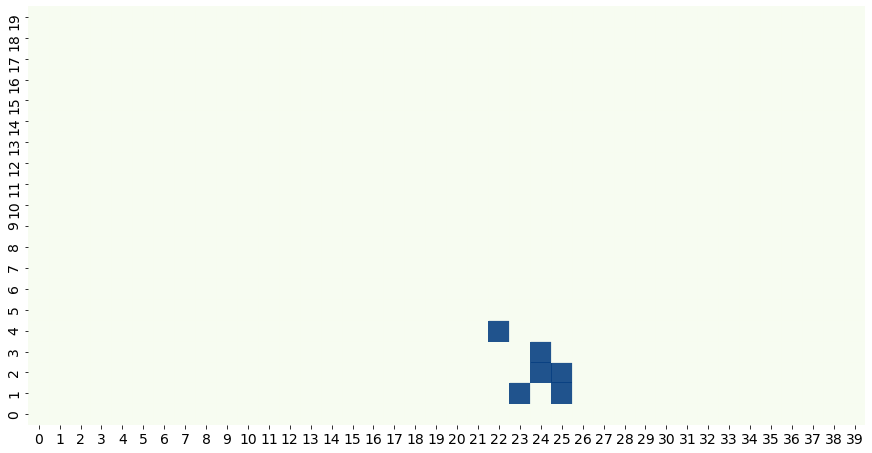

In [10]:
plt.rcParams.update({'font.size': 14})
sns.heatmap(mol_fps['Acceptor']['fp_array'], annot = False, fmt = 'g', cmap = 'GnBu', robust = False, cbar = False, square = True, alpha = 0.9)

plt.gca().invert_yaxis()

#### This visualisation can be calculated for all the six pharmacophores, as shown below 

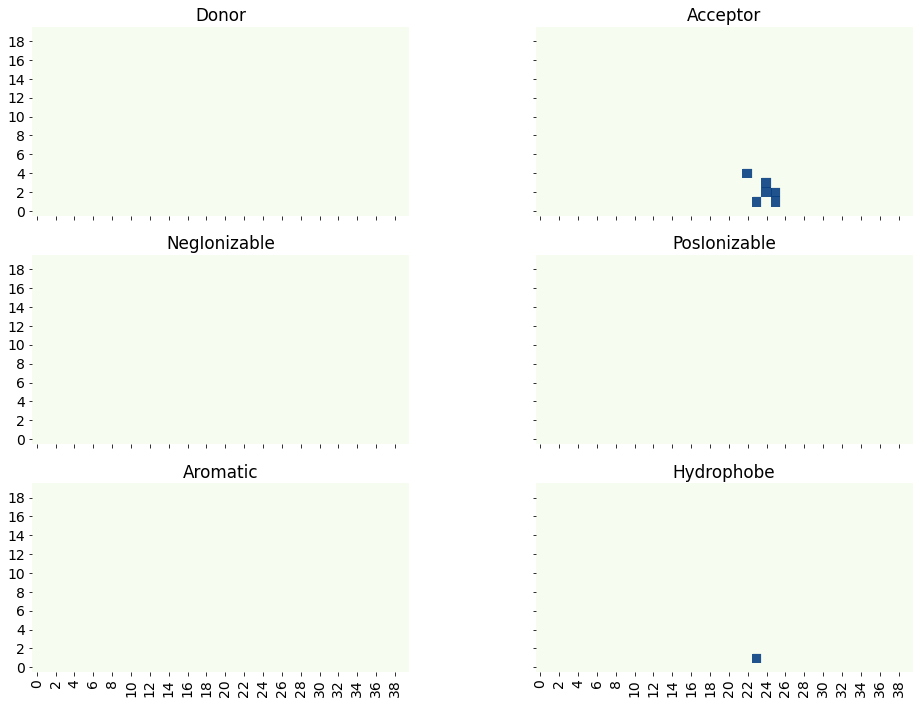

In [11]:
f, (axes) = plt.subplots(nrows = 3, ncols = 2, sharey = True, sharex = True)
for pharmacophore, ax in zip(mol_fps.keys(), chain.from_iterable(axes)):
    array = mol_fps[pharmacophore]['fp_array']
    pharmacophore_name = cp.deepcopy(pharmacophore)
    pharmacophore = sns.heatmap(array, annot = False, cmap = 'GnBu',ax = ax, cbar = False, square = True, robust = False, alpha = 0.9)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(pharmacophore_name)
    plt.gca().invert_yaxis()
f.tight_layout()

## Calculating the mGAP similarity to a molecule
A similar molecule, by mGAP standards, is one that places pharmacophores in similar regions of 3D space.\
This similarity can be calculated by taking the mGAP fingerprint and finding compounds which place 1's in the same locations.\
To do this quantitatively, the Tanimoto similarity of two fingerprints can be calculated.
   - Tanimoto similarity is analagous to the shared proportion of 'on' bits between the molecules
   - In this case, that is the shared proportion of pharmacophores which are placed in the same region of 3D space.\
   
Below, the Tanimoto similarities of the whole set are calculated against the query compound.\
The results are ranked by Tanimoto similarity, and the top 3 hits are shown.\
As expected, the query compound is identical (Tanimoto = 1).\
The next two compounds have a low similarity, indicating partial overlap.\
The histogram below shows the majority of compounds have a similarity < 0.2

,ID,smiles,mGAP_Tc_EN300-12661,Molecule
0,EN300-37470797,C[C@@H]1C[C@@H](CCO1)C(O)=O,1.0,
1,EN300-307391,OC(=O)[C@@H]1CCO[C@@H](C1)C(F)(F)F,1.0,
2,EN300-12661,OC(=O)C1CCOCC1,1.0,

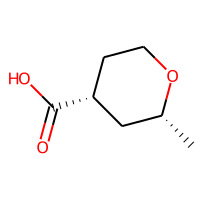
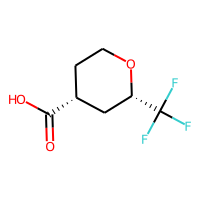
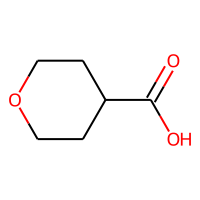

In [12]:
pure_tanimoto = mGAPclustering.calculate_similarity_to_molecule(molname, return_mols = True, metric = 'Tanimoto', prefix = "mGAP_Tc")
pure_tanimoto.head(3)

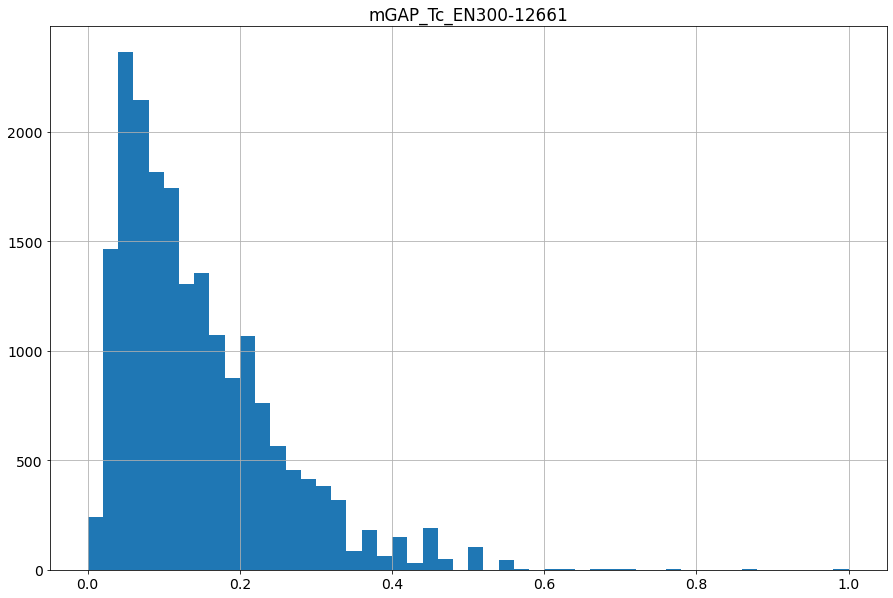

In [13]:
_ = pure_tanimoto.hist('mGAP_Tc_EN300-12661', bins = 50)

#### To visualise the similarities of the two top similar compounds, their fingerprints can be overlapped
The top ranking compounds are shown below.\
The query compound is shown in grey.\
1 - red hue, 2 - green hue

In [14]:
mol_fps_1, _ = GetFPsForMol(pure_tanimoto.iloc[1][0], mGAPclustering, DBconfiguration)
mol_fps_2, _ = GetFPsForMol(pure_tanimoto.iloc[2][0], mGAPclustering, DBconfiguration)

/hpc/apps/2018/anaconda3/v5.0.1b.app/envs/cassapps2020/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/hpc/apps/2018/anaconda3/v5.0.1b.app/envs/cassapps2020/lib/python3.7/site-packages/seaborn/matrix.py:204: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/hpc/apps/2018/anaconda3/v5.0.1b.app/envs/cassapps2020/lib/python3.7/site-packages/seaborn/matrix.py:209: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


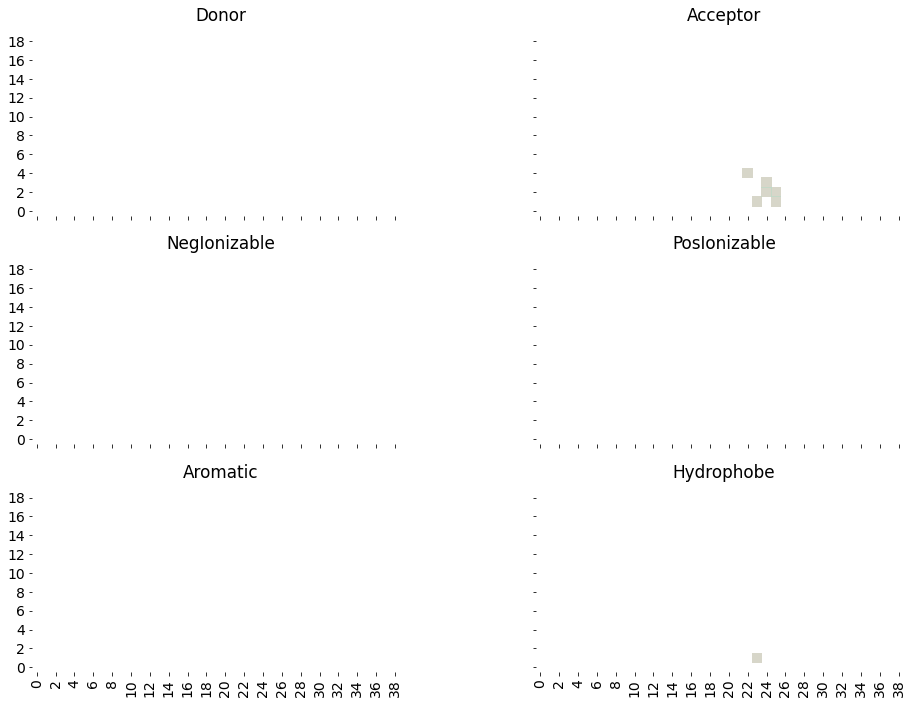

In [15]:
f, (axes) = plt.subplots(nrows = 3, ncols = 2, sharey = True, sharex = True)
for pharmacophore, ax in zip(mol_fps.keys(), chain.from_iterable(axes)):
    array = mol_fps[pharmacophore]['fp_array']
    array1 = np.where(mol_fps_1[pharmacophore]['fp_array'] == 0, np.NaN, mol_fps_1[pharmacophore]['fp_array'])
    array2 = np.where(mol_fps_2[pharmacophore]['fp_array'] == 0, np.NaN, mol_fps_2[pharmacophore]['fp_array'])
    pharmacophore_name = cp.deepcopy(pharmacophore)
    pharmacophore = sns.heatmap(array, annot = False, cmap = 'Greys',ax = ax, cbar = False, square = True, robust = True, alpha = 0.7)
    pharmacophore = sns.heatmap(array1, annot = False, cmap = 'Pastel1',ax = ax, cbar = False, square = True, robust = True, alpha = 0.7)
    pharmacophore = sns.heatmap(array2, annot = False, cmap = 'Pastel2',ax = ax, cbar = False, square = True, robust = False, alpha = 0.5)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(pharmacophore_name)
    plt.gca().invert_yaxis()
f.tight_layout()

#### This method of similarity searching is quite strict, and only classes things as similar if they have a direct overlap in their pharmacophores.
To remedy this, compounds which place pharmacophores in adjacent cells to the query compound (e.g. 0.65 - 1.3 Angstroms away) can be classed as similar\
To do this, the fingerprint of the query can be "bled" i.e. the cells adjacent to the 'on' cells are also turned on.\
A comparison of what the two fingerprints look like is shown below in the heatmaps.

Text(0.5, 1.0, 'Bleed Fingerprint for Acceptor')

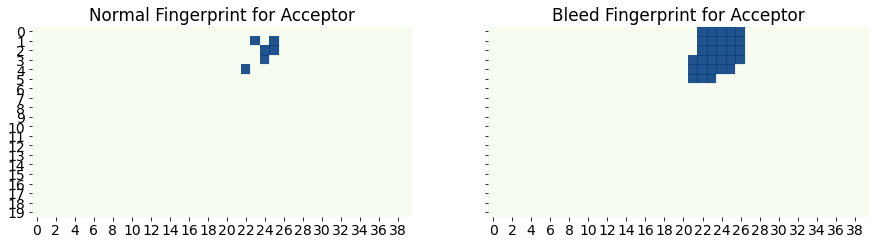

In [16]:
f, (axes) = plt.subplots(nrows = 1, ncols = 2, sharey = True, sharex = True)
example_pharmacophore = 'Acceptor'
normal_fp = mol_fps[example_pharmacophore]['fp_array']
bleed_fp = mol_fps[example_pharmacophore]['fp_bleed_array']
normal_heatmap = sns.heatmap(normal_fp, annot = False, fmt = 'g', cmap = 'GnBu', robust = False, cbar = False, square = True, alpha = 0.9, ax = axes[0])
axes[0].set_title(f'Normal Fingerprint for {example_pharmacophore}')
normal_heatmap = sns.heatmap(bleed_fp, annot = False, fmt = 'g', cmap = 'GnBu', robust = False, cbar = False, square = True, alpha = 0.9, ax = axes[1])
axes[1].set_title(f'Bleed Fingerprint for {example_pharmacophore}')

#### Now, a similarity search can be performed using the new fuzzy fingerprints
This gives completely different compounds to before, because the conditions needed to be "similar" have changed.\
Importantly, the original compound is not considered the most similar.\
The visualisations of overlaps between the top results are shown again below.

,ID,smiles,mGap_fuzzy_Tc_EN300-12661,Molecule
0,EN300-344833,CCOC1COCCC1CC(O)=O,0.700000,
1,EN300-244097,COC1COCCC1CC(O)=O,0.700000,
2,EN300-182610,CC(CS(C)=O)C(O)=O,0.692308,

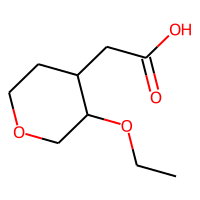
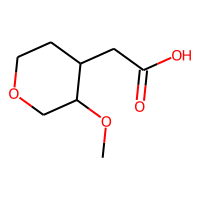
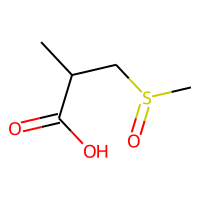

In [17]:
fuzzy_tanimoto = mGAPclustering.calculate_similarity_to_molecule(molname, fuzzy = True, return_mols = True, metric = 'Tanimoto', prefix = "mGap_fuzzy_Tc")
fuzzy_tanimoto.head(3)

In [18]:
mol_fps_3, _ = GetFPsForMol(fuzzy_tanimoto.iloc[1][0], mGAPclustering, DBconfiguration)
mol_fps_4, _ = GetFPsForMol(fuzzy_tanimoto.iloc[2][0], mGAPclustering, DBconfiguration)

/hpc/apps/2018/anaconda3/v5.0.1b.app/envs/cassapps2020/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/hpc/apps/2018/anaconda3/v5.0.1b.app/envs/cassapps2020/lib/python3.7/site-packages/seaborn/matrix.py:204: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/hpc/apps/2018/anaconda3/v5.0.1b.app/envs/cassapps2020/lib/python3.7/site-packages/seaborn/matrix.py:209: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


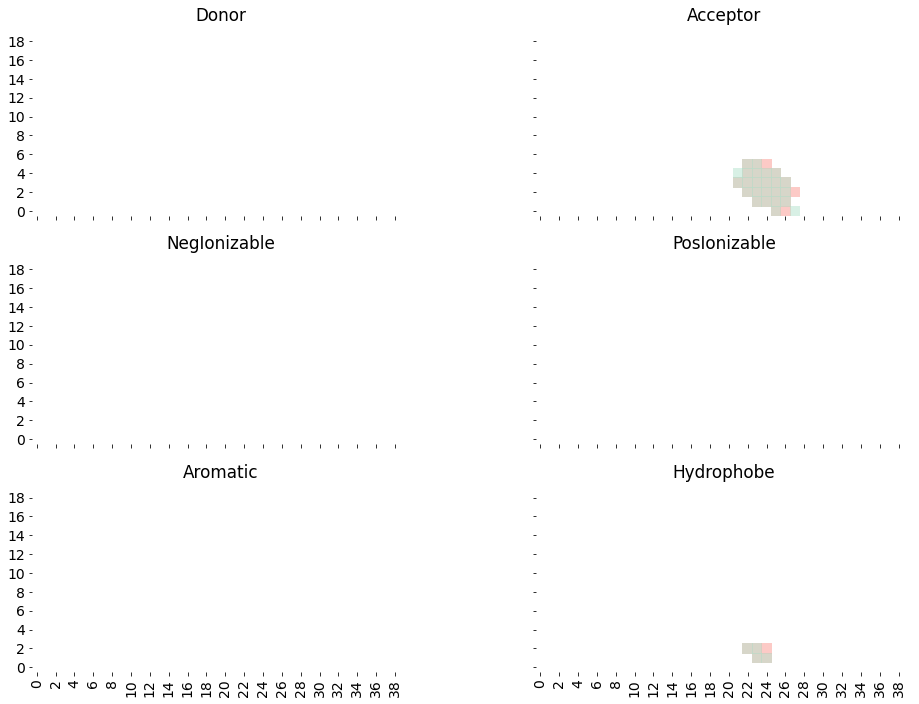

In [19]:
f, (axes) = plt.subplots(nrows = 3, ncols = 2, sharey = True, sharex = True)
for pharmacophore, ax in zip(mol_fps.keys(), chain.from_iterable(axes)):
    array = mol_fps[pharmacophore]['fp_array']
    array1 = np.where(mol_fps_3[pharmacophore]['fp_array'] == 0, np.NaN, mol_fps_3[pharmacophore]['fp_array'])
    array2 = np.where(mol_fps_4[pharmacophore]['fp_array'] == 0, np.NaN, mol_fps_4[pharmacophore]['fp_array'])
    pharmacophore_name = cp.deepcopy(pharmacophore)
    pharmacophore = sns.heatmap(array, annot = False, cmap = 'Greys',ax = ax, cbar = False, square = True, robust = True, alpha = 0.7)
    pharmacophore = sns.heatmap(array1, annot = False, cmap = 'Pastel1',ax = ax, cbar = False, square = True, robust = True, alpha = 0.7)
    pharmacophore = sns.heatmap(array2, annot = False, cmap = 'Pastel2',ax = ax, cbar = False, square = True, robust = False, alpha = 0.5)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(pharmacophore_name)
    plt.gca().invert_yaxis()
f.tight_layout()

#### We can see here that the top ranking compound covers a lot of the space in the Acceptor region as the query compound.
Because the query fingerprint has a lot of added 'on' bits, the Tanimoto similarity become less of an appropriate similarity metric as the proportion of 'on' bits between the query and the target are less important.\
The Tversky allows the proportion to which a penalty is given to on bits in the query that aren't on the target to be changed.\
To remedy this, the Tversky metric, which can reduce the credence of the query 'on' bits can be used. By setting alpha to 0 and beta to 1, the result gives an idea of how well the placement of the target compound fits into the query fingerprint.\
A particular point to highlight here, is that the query compound is not being returned at the top of the list, when it should be amongst the most 'similar'

,ID,smiles,mGAP_fuzzy_sub_Tv_EN300-12661,Molecule
0,EN300-101366,OC(=O)CC1CCCCCC1,1.0,
1,EN300-107439,OC(=O)C1SCCS1,1.0,
2,EN300-107726,CC(OC1CCCCCC1)C(O)=O,1.0,
3,EN300-108310,COCCC1(CCC1)C(O)=O,1.0,
4,EN300-111191,OC(=O)C1CCC1CF,1.0,

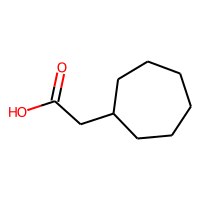
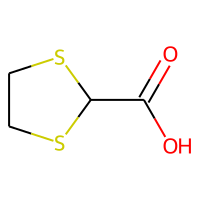
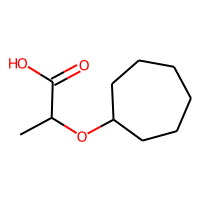
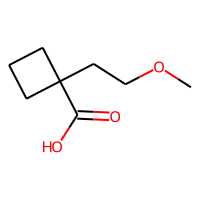
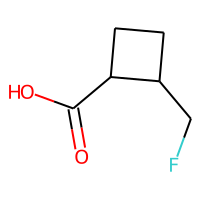

In [20]:
fuzzy_sub_tversky = mGAPclustering.calculate_similarity_to_molecule(molname, fuzzy = True, return_mols = True, metric = 'Tversky', a = 0, b = 1, prefix = "mGAP_fuzzy_sub_Tv")
fuzzy_sub_tversky.head(5)

#### Using a = 0 and b = 1 in the Tversky gives a value of '1' if the target compound's pharmacophore lies completely within the query fingerprint. 
This gives many matches of small compounds which don't have much of a pharmacophore.\
By varying a and b very slightly, we can begin to add weight to the 'on' bits on the query fp that aren't covered by the target compound.\
Upon doing this, we find that our query compound scores highly in the similarity search, as desired.

,ID,smiles,mGAP_fuzzy_Tv_EN300-12661,Molecule
0,EN300-35945,OC(=O)CCC1CCCO1,0.950570,
1,EN300-7470871,CC(CC(O)=O)P(C)(C)=O,0.944882,
2,EN300-131592,COC(C)CCC(O)=O,0.944882,
3,EN300-303894,COC(=O)C1CCOC1C(O)=O,0.944882,
4,EN300-39090,OC(=O)CCS(=O)(=O)C(F)(F)F,0.944882,
5,EN300-3028877,CC1(CC1C(O)=O)C1CCCO1,0.938776,
6,EN300-6816899,OC(=O)C1C2CCS(=O)(=O)C12,0.938776,
7,EN300-373590,OC(=O)CC[C@H]1CCCO1,0.938776,
8,EN300-75745,CS(=O)CCC(O)=O,0.938776,
9,EN300-1695818,COCC1(CC(O)=O)CCOCC1,0.938776,

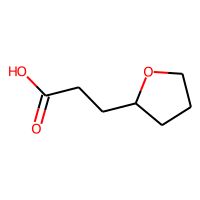
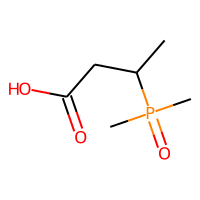
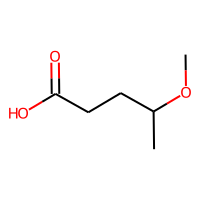
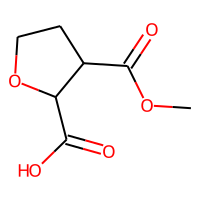
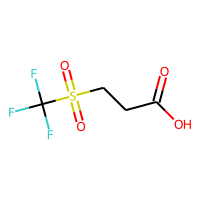
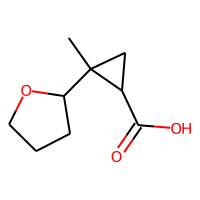
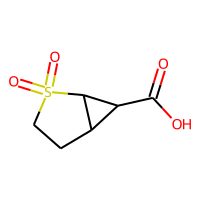
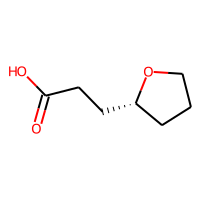
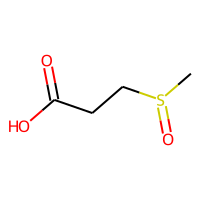
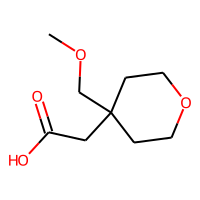

In [21]:
fuzzy_tversky = mGAPclustering.calculate_similarity_to_molecule(molname, fuzzy = True, return_mols = True, metric = 'Tversky', a = 0.1, b = 0.9, prefix = "mGAP_fuzzy_Tv")
fuzzy_tversky.head(10)

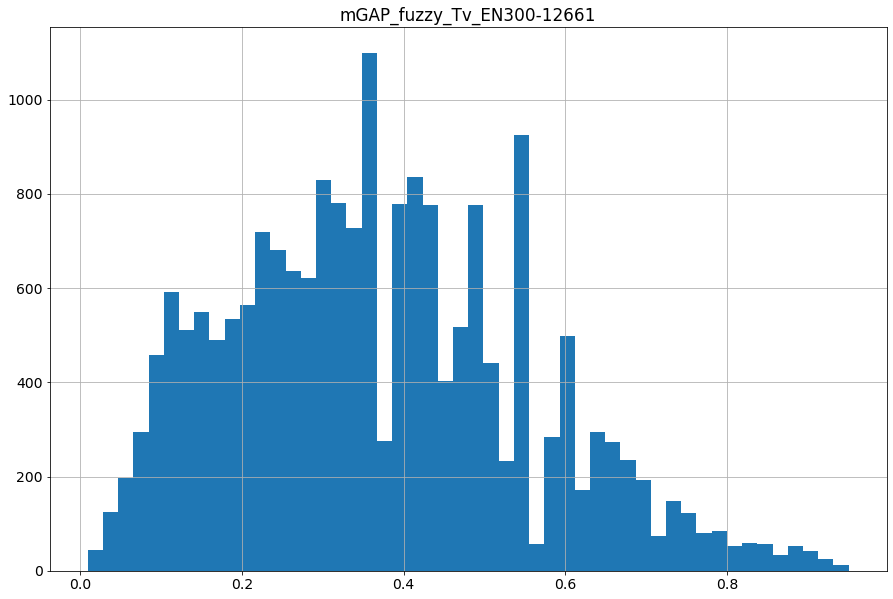

In [22]:
_ = fuzzy_tversky.hist('mGAP_fuzzy_Tv_EN300-12661', bins = 50)

In [23]:
tables = [fuzzy_tversky,fuzzy_sub_tversky,fuzzy_tanimoto,pure_tanimoto]

In [24]:
for i, table in enumerate(tables):
    tables[i].set_index('ID', inplace = True)
    if i>0:
        tables[i].drop(['smiles','Molecule'],axis = 1, inplace = True)

In [25]:
similarity_table = pd.concat(tables, axis = 1)

In [26]:
import pandas as pd
from rdkit import SimDivFilters, Chem, DataStructs
from rdkit.Chem import Draw,Descriptors,rdDepictor, rdMolDescriptors, AllChem, PandasTools, Pharm2D
from rdkit.Chem.Pharm2D import Gobbi_Pharm2D,Generate
from rdkit.Chem.Draw import IPythonConsole

In [27]:
def Similarity(smiles1, smiles2, fingerprint_type = 'Morgan'):
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    if fingerprint_type == 'Morgan':
        fp1 = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol1,2,2048)
        fp2 = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol2,2,2048)
    elif fingerprint_type == "Path":
        fp1 = Chem.RDKFingerprint(mol1)
        fp2 = Chem.RDKFingerprint(mol2)
    elif fingerprint_type == 'Pharm2D':
        fp1 = Generate.Gen2DFingerprint(mol1,Pharm2D.Gobbi_Pharm2D.factory)
        fp2 = Generate.Gen2DFingerprint(mol2,Pharm2D.Gobbi_Pharm2D.factory)
    elif fingerprint_type == 'FeatureMorgan':
        fp1 = AllChem.GetMorganFingerprint(mol1,2,useFeatures=True)
        fp2 = AllChem.GetMorganFingerprint(mol2,2,useFeatures=True)
        return DataStructs.TanimotoSimilarity(fp1,fp2)
    else:
        print('Please define a valid fingerprint type')
        return None
    
    return DataStructs.FingerprintSimilarity(fp1,fp2, metric=DataStructs.TanimotoSimilarity)


fingerprint_types = ['Morgan','Path','Pharm2D','FeatureMorgan']

def GetSimilarityTable(ref_smiles, query_smiles):
    if isinstance(ref_smiles, list):
        pass
    else:
        ref_smiles = [ref_smiles]
    if isinstance(query_smiles, list):
        pass
    else:
        query_smiles = [query_smiles]
    all_smiles = list(dict.fromkeys(list(ref_smiles)+list(query_smiles)))
    smiles_table = pd.DataFrame(all_smiles, columns = ['smiles'])
    PandasTools.AddMoleculeColumnToFrame(smiles_table,'smiles','Molecule',includeFingerprints=True)
    for num, ref in enumerate(list(ref_smiles)):
        for i in smiles_table.index:
                        
            for fingerprint_type in fingerprint_types:
                smiles_table.loc[i,f'{fingerprint_type} Tc({num})'] = Similarity(ref, smiles_table.loc[i,'smiles'], fingerprint_type)
            
    
    return smiles_table

In [28]:
ref_smiles = mGAPclustering._ref_table.loc[molname]['smiles']
for i in similarity_table.index:
    for fingerprint_type in fingerprint_types:
        similarity_table.loc[i, f'{fingerprint_type}_{molname}'] = Similarity(ref_smiles, similarity_table.loc[i,'smiles'], fingerprint_type)

In [29]:
similarity_table['mGAP_combined'] = similarity_table[[f"mGAP_Tc_{molname}", f"mGAP_fuzzy_Tv_{molname}"]].max(axis=1)

,smiles,mGAP_fuzzy_Tv_EN300-12661,Molecule,mGAP_fuzzy_sub_Tv_EN300-12661,mGap_fuzzy_Tc_EN300-12661,mGAP_Tc_EN300-12661,Morgan_EN300-12661,Path_EN300-12661,Pharm2D_EN300-12661,FeatureMorgan_EN300-12661,mGAP_combined
EN300-35945,OC(=O)CCC1CCCO1,0.950570,,1.0,0.657895,0.280000,0.281250,0.402367,0.230769,0.472222,0.950570
EN300-7470871,CC(CC(O)=O)P(C)(C)=O,0.944882,,1.0,0.631579,0.291667,0.125000,0.163636,0.116279,0.324324,0.944882
EN300-131592,COC(C)CCC(O)=O,0.944882,,1.0,0.631579,0.291667,0.121212,0.419847,0.190476,0.411765,0.944882
EN300-303894,COC(=O)C1CCOC1C(O)=O,0.944882,,1.0,0.631579,0.240000,0.303030,0.296512,0.285714,0.390244,0.944882
EN300-39090,OC(=O)CCS(=O)(=O)C(F)(F)F,0.944882,,1.0,0.631579,0.291667,0.121212,0.107570,0.089286,0.285714,0.944882

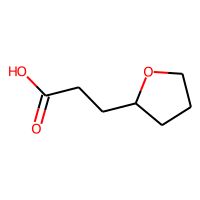
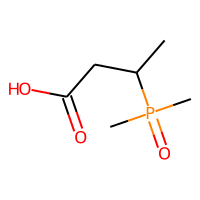
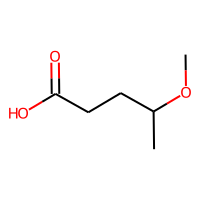
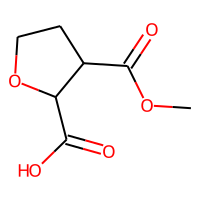
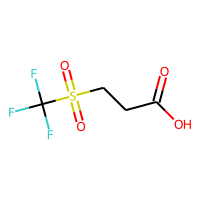

In [30]:
similarity_table.head()

<AxesSubplot:xlabel='mGAP_fuzzy_Tv_EN300-12661', ylabel='FeatureMorgan_EN300-12661'>

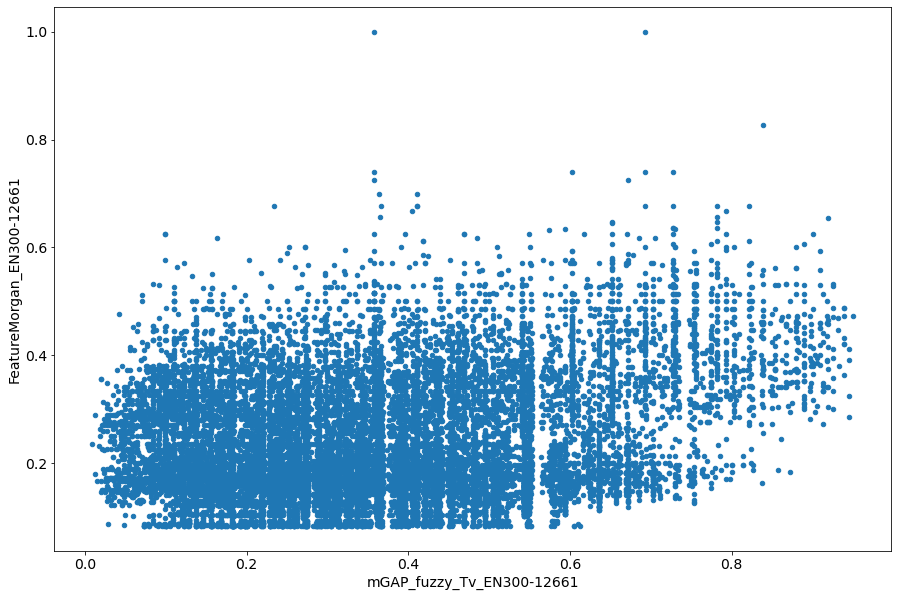

In [31]:
similarity_table.plot.scatter(f'mGAP_fuzzy_Tv_{molname}',f'FeatureMorgan_{molname}')

In [32]:
sim_columns = f"mGAP_fuzzy_Tv_{molname}	mGAP_fuzzy_sub_Tv_{molname}	mGap_fuzzy_Tc_{molname}	mGAP_Tc_{molname}	Morgan_{molname}	Path_{molname}	Pharm2D_{molname}	FeatureMorgan_{molname}"

In [33]:
sim_columns = sim_columns.split('\t')
#sim_columns = ['mGAP_fuzzy_Tv_EM40391702', 'mGAP_fuzzy_sub_Tv_EM40391702', 'mGap_fuzzy_Tc_EM40391702', 'mGAP_Tc_EM40391702', 'Morgan_EM40391702', 'Path_EM40391702', 'Pharm2D_EM40391702', 'FeatureMorgan_EM40391702']

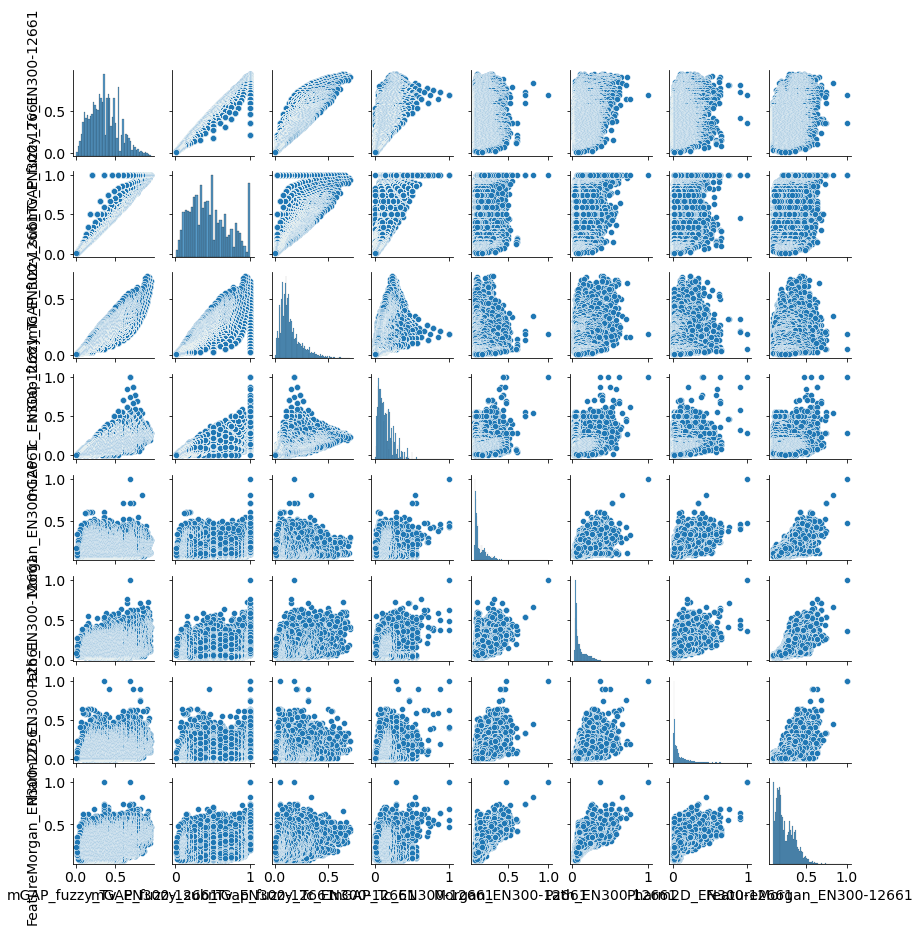

In [34]:
sns.pairplot(similarity_table[sim_columns], height = 1.5)

<AxesSubplot:xlabel='mGAP_fuzzy_Tv_EN300-12661', ylabel='mGAP_combined'>

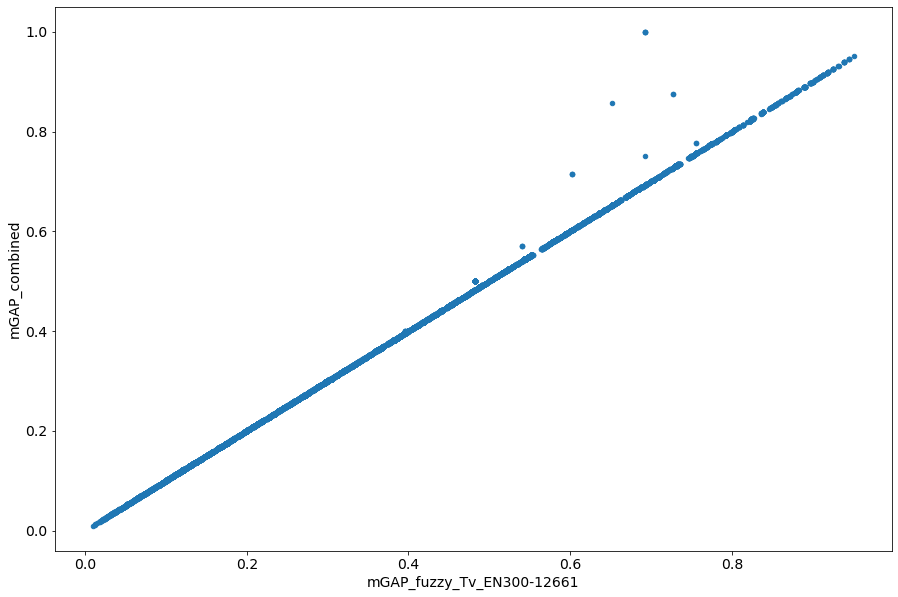

In [35]:
similarity_table.plot.scatter(f'mGAP_fuzzy_Tv_{molname}','mGAP_combined')

In [36]:
ECFP_sim_table = GetSimilarityTable('OC(=O)C1CCOCC1',similarity_table['smiles'].tolist())

,smiles,Molecule,Morgan_EN300-12661
EN300-12661,OC(=O)C1CCOCC1,,1.000000
EN300-188092,OC(=O)C1CCCOCC1,,0.809524
EN300-170463,OC(=O)[C@H]1CCOC1,,0.714286
EN300-697519,OC(=O)[C@@H]1CCOC1,,0.714286
EN300-53423,OC(=O)C1CCOC1,,0.714286
EN300-126761,OC(=O)[C@H]1CC[C@@H](CC1)C(O)=O,,0.611111
EN300-20569,OC(=O)C1CCC(CC1)C(O)=O,,0.611111
EN300-141859,OC(=O)[C@H]1CC[C@H](CC1)C(O)=O,,0.611111
EN300-19510,OC(=O)C1CC1,,0.611111
EN300-313440,OC(=O)C1CN(C1)C1CCOCC1,,0.600000

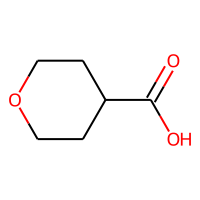
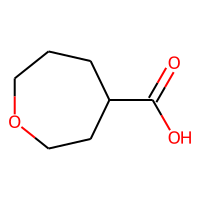
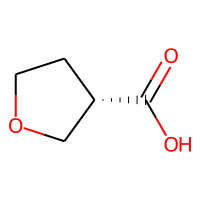
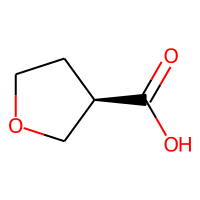
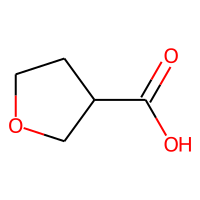
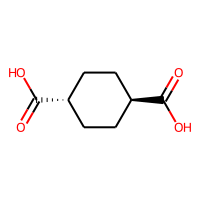
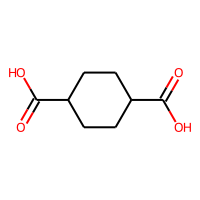
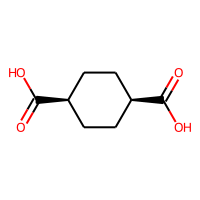
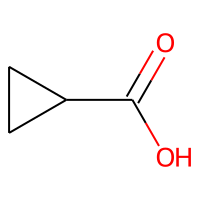
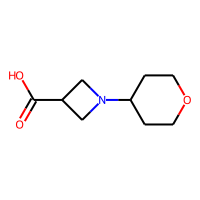
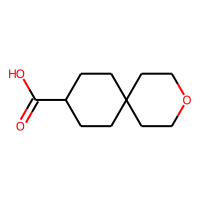
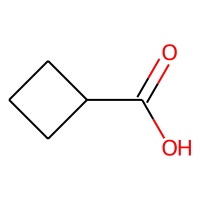
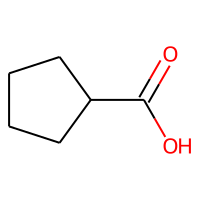
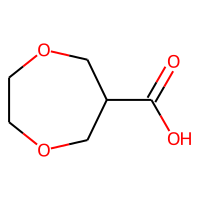
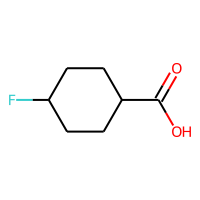
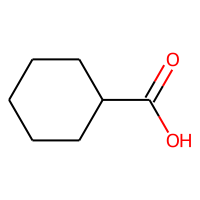
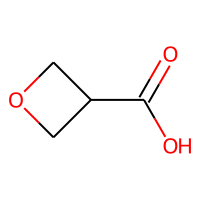
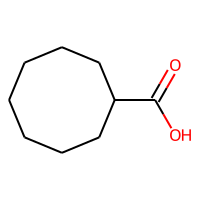
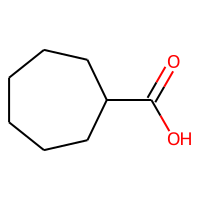
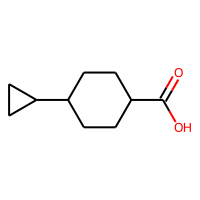

In [37]:
metric = f'Morgan_{molname}'
similarity_table.sort_values(metric, ascending = False).head(20)[['smiles','Molecule',metric]]